Independent Joint Control - PD

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[-0.60867435  1.29329714  0.15       -0.01000918 -0.02024433  0.        ]


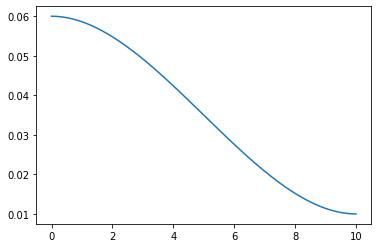

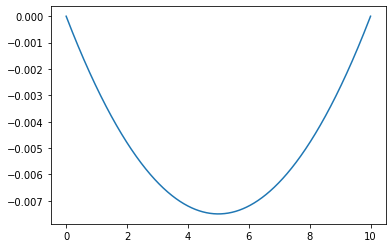

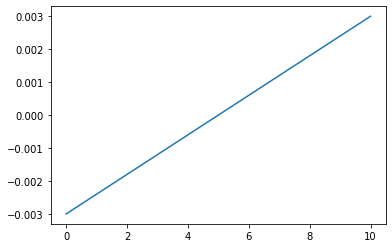

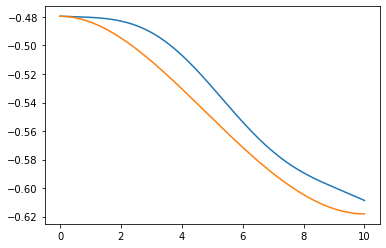

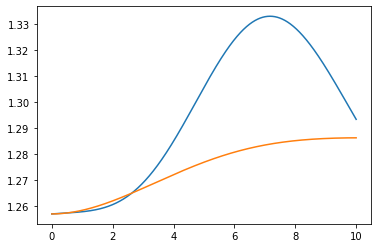

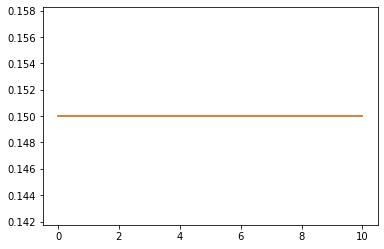

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import sympy as sym
import scipy
from scipy.integrate import odeint

class manipulator():

  def __init__(self, no_of_links, type_of_joints, dh_params):
    super().__init__()
    self.no_of_links = no_of_links
    self.type_of_joints = list(type_of_joints)
    self.dh_params = dh_params
    if len(self.dh_params) != self.no_of_links:
      print("ERROR: Please make sure the number of rows in the DH parameters provided is equal to the number of links.")
      sys.exit()
    self.dh_matrices = []
    for i in range(0, self.no_of_links):    
      temp = self.dh_params[i]
      theta = temp[0]
      d = temp[1]
      a = temp[2]
      alpha = temp[3]
      A1 = np.array([[np.cos(theta), -np.sin(theta), 0, 0],[np.sin(theta), np.cos(theta), 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A2 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, d],[0, 0, 0, 1]])
      A3 = np.array([[1, 0, 0, a],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A4 = np.array([[1, 0, 0, 0],[0, np.cos(alpha), -np.sin(alpha), 0],[0, np.sin(alpha), np.cos(alpha), 0],[0, 0, 0, 1]])
      # print(A3)
      A_final = A1@A2@A3@A4
      self.dh_matrices.append(A_final)
    self.dh_matrices = np.array(self.dh_matrices)

    self.transform_matrices = []
    self.rotation_matrices = []

    for i in range(1, self.no_of_links+1):
      temp = self.dh_matrices[0]
      for j in range(1, i):
        temp = temp@self.dh_matrices[j]
      rot_temp = temp
      rot_temp = np.delete(rot_temp, (3), axis = 0)
      rot_temp = np.delete(rot_temp, (3), axis = 1)
      self.transform_matrices.append(temp)
      self.rotation_matrices.append(rot_temp)

    self.transform_matrices = np.array(self.transform_matrices)
    self.rotation_matrices = np.array(self.rotation_matrices)

    self.end_effector_posn = np.delete(self.transform_matrices[len(self.transform_matrices)-1]@np.array([[0],[0],[0],[1]]), (3), axis = 0)

  def getJv(self):
    self.z = []
    self.origins = []
    self.z.append(np.array([[0],[0],[1]]))
    self.origins.append(np.array([[0],[0],[0]]))

    for i in range(0, self.no_of_links):
      temp_z = self.rotation_matrices[i]@np.array([[0],[0],[1]])
      self.z.append(temp_z)
      temp_origin = self.transform_matrices[i]@np.array([[0],[0],[0],[1]])
      temp_origin = np.delete(temp_origin, (3), axis = 0)
      self.origins.append(temp_origin)
    
    self.z = np.array(self.z)
    self.origins = np.array(self.origins)  
    self.jacobian = []
    for i in range(0,self.no_of_links):
      if self.type_of_joints[i] == "R":
        temp_1 = np.cross(self.z[i], self.end_effector_posn-self.origins[i], axis = 0)
        temp_2 = self.z[i]
      if self.type_of_joints[i] == "P":
        temp_1 = self.z[i]
        temp_2 = np.array([[0],[0],[0]])
      temp_jacobian = np.vstack((temp_1, temp_2))
      self.jacobian.append(temp_jacobian)
    self.jacobian = np.array(self.jacobian)
    self.jacobian = self.jacobian.reshape((self.no_of_links,6))
    self.jacobian = np.transpose(self.jacobian)
    self.Jv = np.delete(self.jacobian,(3,4,5), axis = 0)
  # creating a new method to calculate the joint
  # velocities, given the Jacobian matrix and 
  # the cartesian velocity.
  # Velocity in x,y and z direction is required
  # as input.
  def joint_velocities(self, xdot, ydot, zdot):
    Xdot =  np.array([[xdot],[ydot],[zdot]])
    # First, it is required to check whether this 
    # velocity is possible in this configuration.
    # This is done by comparing the rank of the
    # Jacobian and the rank of the augmented matrix
    # of the Jacobian and Xdot. If the two are equal,
    # then the velocity is possible.
    # rank_J = np.linalg.matrix_rank(self.Jv)
    # rank_augmented = np.linalg.matrix_rank(np.hstack((self.Jv,Xdot)))
    # if rank_J != rank_augmented:
    #   print("ERROR: Please make sure the velocities provided by you are possible in this configuration.")
    #   sys.exit()
    # If the given cartesian velocity is possible,
    # the joint velocities can be calculated by
    # multiplying Xdot with the pseudo-inverse
    # of the Jacobian matrix.
    qdot = np.linalg.pinv(self.Jv)@Xdot

    return qdot

def scara_invkin( x,y,z,d1,d2,d4):
    # using formulae from the textbook
    r = abs((x**2+y**2-d1**2-d2**2)/(2*d1*d2))
    theta2 = math.atan2(np.sqrt(abs(1-r**2)),r)
    theta1 = math.atan2(y,x) - math.atan2((d2*np.sin(theta2)),(d1+d2*np.cos(theta2)))
    d3 = d4-z
    return (theta1, theta2, d3)

x0 = 0.4
y0 = 0.06
z0 = 0.1
x1 = 0.4
y1 = 0.01
z1 = 0.1
t0 = 0
tf = 10

A = np.array([[1,t0,t0**2,t0**3],[0,1,2*t0,3*t0**2],[1,tf,tf**2,tf**3],[0,1,2*tf,3*tf**2]])
q = np.array([[y0,0,y1,0]])
B = np.linalg.inv(A)@np.transpose(q)
a0 = B[0]
a1 = B[1]
a2 = B[2]
a3 = B[3]

time_vector = np.linspace(t0,tf,1000)
y_trajectory = []
ydot_trajectory = []
yddot_trajectory = []

for i in range(0,len(time_vector)):
    y_trajectory.append(a0+a1*time_vector[i]+a2*time_vector[i]**2+a3*time_vector[i]**3)
    ydot_trajectory.append(a1 + 2*a2*time_vector[i] + 3*a3*time_vector[i]**2)
    yddot_trajectory.append(2*a2 + 6*a3*time_vector[i])

plt.figure()
plt.plot(time_vector,y_trajectory)
plt.figure()
plt.plot(time_vector,ydot_trajectory)
plt.figure()
plt.plot(time_vector,yddot_trajectory)

theta1_trajectory = []
theta2_trajectory = []
d3_trajectory = []

for j in range(0,len(time_vector)):
  (theta1,theta2,d3) = scara_invkin(x0,y_trajectory[j],z0,0.25,0.25,0.25)
  theta1_trajectory.append(theta1)
  theta2_trajectory.append(theta2)
  d3_trajectory.append(d3)

# plt.figure()
# plt.plot(time_vector,theta1_trajectory)
# plt.figure()
# plt.plot(time_vector,theta2_trajectory)
# plt.figure()
# plt.plot(time_vector,d3_trajectory)

theta1dot_trajectory = []
theta2dot_trajectory = []
d3dot_trajectory = []

for k in range(0,len(time_vector)):
  scara = manipulator(3, "RRP", [[theta1_trajectory[k],0,0.25,0],[theta2_trajectory[k],0,0.25,np.pi],[0,0,d3_trajectory[k],0]])
  jacobian_velocity = scara.getJv()
  qdot = scara.joint_velocities(0,ydot_trajectory[k],0)
  theta1dot_trajectory.append(qdot[0])
  theta2dot_trajectory.append(qdot[1])
  d3dot_trajectory.append(qdot[2])

# plt.figure()
# plt.plot(time_vector,theta1dot_trajectory)
# plt.figure()
# plt.plot(time_vector,theta2dot_trajectory)
# plt.figure()
# plt.plot(time_vector,d3dot_trajectory)

A = [x0,y0,z0]
B = [x1,y1,z1]
d1 = 0.25
d2 = 0.25
d3 = 0.25
A_joint_vars = scara_invkin(A[0],A[1],A[2],d1,d2,d3)
B_joint_vars = scara_invkin(B[0],B[1],B[2],d1,d2,d3)
[q1d, q2d, q3d] = B_joint_vars
[q1, q2, q3] = A_joint_vars

# Independent joint control - PD 

Kp1 = 0.5
Kp2 = 0.3
Kp3 = 10
Kd1 = 0.3
Kd2 = 0.2
Kd3 = 0.3

tau1 = Kp1*(q1d-q1)
tau2 = Kp2*(q2d-q2)
tau3 = 9.8+Kp3*(q3d-q3)

def func(t,y):
  
  global tau1
  global tau2
  global tau3
  q1 = y[0]
  q2 = y[1]
  q3 = y[2]
  q1dot = y[3]
  q2dot = y[4]
  q3dot = y[5]

  I1 = 1
  I2 = 1
  I3 = 1
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 0.25
  l2 = 0.25

  alpha = I1 + m1*(l1/2)**2 + m2*l1**2 + m3*l1**2
  beta = I2 + I3 + m3*l2**2 + +m2*(l2/2)**2
  gamma = l1*l2*m3 + (m2*l1*l2)/2

  M = np.array([[alpha+beta+2*gamma*np.cos(q2), beta+gamma*np.cos(q2),0],[beta+gamma*np.cos(q2), beta, 0],[0, 0, m3]])
  C = np.array([[-gamma*q2dot*np.sin(q2), -gamma*(q1dot+q2dot)*np.sin(q2), 0],[gamma*q1dot*np.sin(q2), 0, 0], [0, 0, 0]])
  G = np.array([[0],[0],[9.8*m3]])
  torque = np.array([[tau1],[tau2],[tau3]])
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  qddot = np.linalg.inv(M)@(torque - C@qdot - G)

  dydt = np.vstack((qdot, qddot))

  return dydt

ode = scipy.integrate.ode(func).set_integrator('vode', nsteps=500, method='bdf')

state = [q1,q2,q3,0,0,0]
dt = 0.01

q1t = [q1]
q2t = [q2]
q3t = [q3]
q1dt = [0]
q2dt = [0]
q3dt = [0]

for i in range(1,len(time_vector)):
  time = time_vector[i]
  ode.set_initial_value(state,time)
  newstate = ode.integrate(ode.t+dt)
  state = newstate

  if i==1:
    tau1 = Kp1*(theta1_trajectory[i]-state[0])
    tau2 = Kp2*(theta2_trajectory[i]-state[1])
    tau3 = 9.8 + Kp3*(d3_trajectory[i]-state[2])

  if i>1 and i<len(time_vector):
    tau1 = Kp1*(theta1_trajectory[i-1]-q1t[i-1])+Kd1*(theta1_trajectory[i-1]-q1t[i-1]-theta1_trajectory[i-2]+q1t[i-2])
    tau2 = Kp2*(theta2_trajectory[i-1]-q2t[i-1])+Kd2*(theta2_trajectory[i-1]-q2t[i-1]-theta2_trajectory[i-2]+q2t[i-2])
    tau3 = 9.8 + Kp3*(d3_trajectory[i-1]-q3t[i-1])+Kd3*(d3_trajectory[i-1]-q3t[i-1]-d3_trajectory[i-2]+q3t[i-2])

  q1t.append(state[0])
  q2t.append(state[1])
  q3t.append(state[2])
  q1dt.append(state[3])
  q2dt.append(state[4])
  q3dt.append(state[5])

print(state)

plt.figure()
plt.plot(time_vector, q1t)
plt.plot(time_vector,theta1_trajectory)
plt.show()
plt.figure()
plt.plot(time_vector, q2t)
plt.plot(time_vector,theta2_trajectory)
plt.show()
plt.figure()
plt.plot(time_vector, q3t)
plt.plot(time_vector,d3_trajectory)
plt.show()

Independent Joint Control - PD with Feedforward

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


-0.015433575962030639 0.0014285496671527437 9.8
[-0.59683684  1.32383698  0.15        0.02475373 -0.03766047  0.        ]


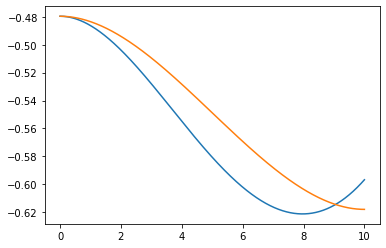

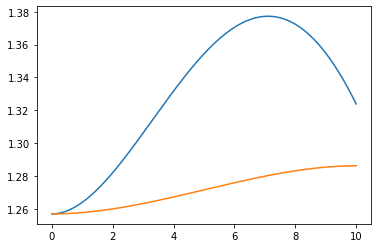

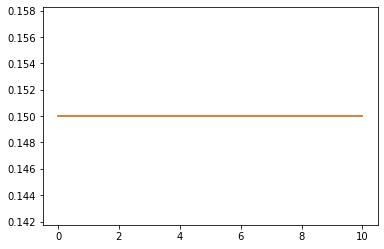

In [92]:
# Independent joint control - PD with feedforward

import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import sympy as sym
import scipy
from scipy.integrate import odeint

class manipulator():

  def __init__(self, no_of_links, type_of_joints, dh_params):
    super().__init__()
    self.no_of_links = no_of_links
    self.type_of_joints = list(type_of_joints)
    self.dh_params = dh_params
    if len(self.dh_params) != self.no_of_links:
      print("ERROR: Please make sure the number of rows in the DH parameters provided is equal to the number of links.")
      sys.exit()
    self.dh_matrices = []
    for i in range(0, self.no_of_links):    
      temp = self.dh_params[i]
      theta = temp[0]
      d = temp[1]
      a = temp[2]
      alpha = temp[3]
      A1 = np.array([[np.cos(theta), -np.sin(theta), 0, 0],[np.sin(theta), np.cos(theta), 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A2 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, d],[0, 0, 0, 1]])
      A3 = np.array([[1, 0, 0, a],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A4 = np.array([[1, 0, 0, 0],[0, np.cos(alpha), -np.sin(alpha), 0],[0, np.sin(alpha), np.cos(alpha), 0],[0, 0, 0, 1]])
      # print(A3)
      A_final = A1@A2@A3@A4
      self.dh_matrices.append(A_final)
    self.dh_matrices = np.array(self.dh_matrices)

    self.transform_matrices = []
    self.rotation_matrices = []

    for i in range(1, self.no_of_links+1):
      temp = self.dh_matrices[0]
      for j in range(1, i):
        temp = temp@self.dh_matrices[j]
      rot_temp = temp
      rot_temp = np.delete(rot_temp, (3), axis = 0)
      rot_temp = np.delete(rot_temp, (3), axis = 1)
      self.transform_matrices.append(temp)
      self.rotation_matrices.append(rot_temp)

    self.transform_matrices = np.array(self.transform_matrices)
    self.rotation_matrices = np.array(self.rotation_matrices)

    self.end_effector_posn = np.delete(self.transform_matrices[len(self.transform_matrices)-1]@np.array([[0],[0],[0],[1]]), (3), axis = 0)

  def getJv(self):
    self.z = []
    self.origins = []
    self.z.append(np.array([[0],[0],[1]]))
    self.origins.append(np.array([[0],[0],[0]]))

    for i in range(0, self.no_of_links):
      temp_z = self.rotation_matrices[i]@np.array([[0],[0],[1]])
      self.z.append(temp_z)
      temp_origin = self.transform_matrices[i]@np.array([[0],[0],[0],[1]])
      temp_origin = np.delete(temp_origin, (3), axis = 0)
      self.origins.append(temp_origin)
    
    self.z = np.array(self.z)
    self.origins = np.array(self.origins)  
    self.jacobian = []
    for i in range(0,self.no_of_links):
      if self.type_of_joints[i] == "R":
        temp_1 = np.cross(self.z[i], self.end_effector_posn-self.origins[i], axis = 0)
        temp_2 = self.z[i]
      if self.type_of_joints[i] == "P":
        temp_1 = self.z[i]
        temp_2 = np.array([[0],[0],[0]])
      temp_jacobian = np.vstack((temp_1, temp_2))
      self.jacobian.append(temp_jacobian)
    self.jacobian = np.array(self.jacobian)
    self.jacobian = self.jacobian.reshape((self.no_of_links,6))
    self.jacobian = np.transpose(self.jacobian)
    self.Jv = np.delete(self.jacobian,(3,4,5), axis = 0)
    self.Jv = self.Jv.reshape((self.no_of_links,3))
    Jv_new = np.array([[self.Jv[0,0],self.Jv[0,1],self.Jv[0,2]],[self.Jv[1,0],self.Jv[1,1],self.Jv[1,2]],[self.Jv[2,0],self.Jv[2,1],self.Jv[2,2]]])
    return Jv_new
  # creating a new method to calculate the joint
  # velocities, given the Jacobian matrix and 
  # the cartesian velocity.
  # Velocity in x,y and z direction is required
  # as input.

  def joint_velocities(self, xdot, ydot, zdot):
    Xdot =  np.array([[xdot],[ydot],[zdot]])
    # First, it is required to check whether this 
    # velocity is possible in this configuration.
    # This is done by comparing the rank of the
    # Jacobian and the rank of the augmented matrix
    # of the Jacobian and Xdot. If the two are equal,
    # then the velocity is possible.
    # rank_J = np.linalg.matrix_rank(self.Jv)
    # rank_augmented = np.linalg.matrix_rank(np.hstack((self.Jv,Xdot)))
    # if rank_J != rank_augmented:
    #   print("ERROR: Please make sure the velocities provided by you are possible in this configuration.")
    #   sys.exit()
    # If the given cartesian velocity is possible,
    # the joint velocities can be calculated by
    # multiplying Xdot with the pseudo-inverse
    # of the Jacobian matrix.
    qdot = np.linalg.pinv(self.Jv)@Xdot

    return qdot

  def get_end_eff_posn(self):
    return self.end_effector_posn

def scara_invkin( x,y,z,d1,d2,d4):
    # using formulae from the textbook
    r = abs((x**2+y**2-d1**2-d2**2)/(2*d1*d2))
    theta2 = math.atan2(np.sqrt(abs(1-r**2)),r)
    theta1 = math.atan2(y,x) - math.atan2((d2*np.sin(theta2)),(d1+d2*np.cos(theta2)))
    d3 = d4-z
    return (theta1, theta2, d3)

x0 = 0.4
y0 = 0.06
z0 = 0.1
x1 = 0.4
y1 = 0.01
z1 = 0.1
t0 = 0
tf = 10

(q10,q20,q30) = scara_invkin(x0,y0,z0,0.25,0.25,0.25)
(q1f,q2f,q3f) = scara_invkin(x1,y1,z1,0.25,0.25,0.25)

A = np.array([[1,t0,t0**2,t0**3],[0,1,2*t0,3*t0**2],[1,tf,tf**2,tf**3],[0,1,2*tf,3*tf**2]])
q1_mat = np.array([[q10,0,q1f,0]])
B1 = np.linalg.inv(A)@np.transpose(q1_mat)
a01 = B1[0]
a11 = B1[1]
a21 = B1[2]
a31 = B1[3]

q2_mat = np.array([[q20,0,q2f,0]])
B2 = np.linalg.inv(A)@np.transpose(q2_mat)
a02 = B2[0]
a12 = B2[1]
a22 = B2[2]
a32 = B2[3]

q3_mat = np.array([[q30,0,q3f,0]])
B3 = np.linalg.inv(A)@np.transpose(q3_mat)
a03 = B3[0]
a13 = B3[1]
a23 = B3[2]
a33 = B3[3]

time_vector = np.linspace(t0,tf,1000)

theta1_trajectory = []
theta2_trajectory = []
d3_trajectory = []
theta1dot_trajectory = []
theta2dot_trajectory = []
d3dot_trajectory = []
theta1ddot_trajectory = []
theta2ddot_trajectory = []
d3ddot_trajectory = []

for j in range(0,len(time_vector)):

  theta1 = a01 + a11*time_vector[j] + a21*time_vector[j]**2 + a31*time_vector[j]**3
  theta2 = a02 + a12*time_vector[j] + a22*time_vector[j]**2 + a32*time_vector[j]**3
  d3 = a03 + a13*time_vector[j] + a23*time_vector[j]**2 + a33*time_vector[j]**3

  theta1dot = a11 + 2*a21*time_vector[j] + 3*a31*time_vector[j]**2
  theta2dot = a12 + 2*a22*time_vector[j] + 3*a32*time_vector[j]**2
  d3dot = a13 + 2*a23*time_vector[j] + 3*a33*time_vector[j]**2

  theta1ddot = 2*a21 + 6*a31*time_vector[j]
  theta2ddot = 2*a22 + 6*a32*time_vector[j]
  d3ddot = 2*a23 + 6*a33*time_vector[j]

  theta1_trajectory.append(theta1)
  theta2_trajectory.append(theta2)
  d3_trajectory.append(d3)

  theta1dot_trajectory.append(theta1dot)
  theta2dot_trajectory.append(theta2dot)
  d3dot_trajectory.append(d3dot)

  theta1ddot_trajectory.append(theta1ddot)
  theta2ddot_trajectory.append(theta2ddot)
  d3ddot_trajectory.append(d3ddot)

y_trajectory = []
ydot_trajectory = []

for k in range(0,len(time_vector)):
  scara = manipulator(3, "RRP", [[theta1_trajectory[k],0,0.25,0],[theta2_trajectory[k],0,0.25,np.pi],[0,0,d3_trajectory[k],0]])
  (x,y,z) = scara.get_end_eff_posn()
  y_trajectory.append(y)
  Jv =  scara.getJv()
  qdot = np.array([[theta1],[theta2],[d3]])
  Xdot = Jv@qdot
  ydot = Xdot[1]
  ydot_trajectory.append(ydot)

# plt.figure()
# plt.plot(time_vector,y_trajectory)
# plt.figure()
# plt.plot(time_vector,ydot_trajectory)
# plt.figure()
# plt.plot(time_vector,yddot_trajectory)

# plt.figure()
# plt.plot(time_vector,theta1_trajectory)
# plt.figure()
# plt.plot(time_vector,theta2_trajectory)
# plt.figure()
# plt.plot(time_vector,d3_trajectory)

# plt.figure()
# plt.plot(time_vector,theta1dot_trajectory)
# plt.figure()
# plt.plot(time_vector,theta2dot_trajectory)
# plt.figure()
# plt.plot(time_vector,d3dot_trajectory)

A = [x0,y0,z0]
B = [x1,y1,z1]
d1 = 0.25
d2 = 0.25
d3 = 0.25
A_joint_vars = scara_invkin(A[0],A[1],A[2],d1,d2,d3)
B_joint_vars = scara_invkin(B[0],B[1],B[2],d1,d2,d3)
[q1d, q2d, q3d] = B_joint_vars
[q1, q2, q3] = A_joint_vars

Kp1 = 0.02
Kp2 = 0.04
Kp3 = 10
Kd1 = 0.05
Kd2 = 7
Kd3 = 0.3

tau1 = Kp1*(q1d-q1)
tau2 = Kp2*(q2d-q2)
tau3 = 9.8+Kp3*(q3d-q3)

def func(t,y):
  
  global tau1
  global tau2
  global tau3
  q1 = y[0]
  q2 = y[1]
  q3 = y[2]
  q1dot = y[3]
  q2dot = y[4]
  q3dot = y[5]

  I1 = 1
  I2 = 1
  I3 = 1
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 0.25
  l2 = 0.25

  alpha = I1 + m1*(l1/2)**2 + m2*l1**2 + m3*l1**2
  beta = I2 + I3 + m3*l2**2 + +m2*(l2/2)**2
  gamma = l1*l2*m3 + (m2*l1*l2)/2

  M = np.array([[alpha+beta+2*gamma*np.cos(q2), beta+gamma*np.cos(q2),0],[beta+gamma*np.cos(q2), beta, 0],[0, 0, m3]])
  C = np.array([[-gamma*q2dot*np.sin(q2), -gamma*(q1dot+q2dot)*np.sin(q2), 0],[gamma*q1dot*np.sin(q2), 0, 0], [0, 0, 0]])
  G = np.array([[0],[0],[9.8*m3]])
  torque = np.array([[tau1],[tau2],[tau3]])
  torque = np.reshape(torque,(3,1))
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  qddot = np.linalg.inv(M)@(torque - C@qdot - G)

  dydt = np.vstack((qdot, qddot))

  return dydt

def get_diag_D(q2):
  I1 = 1
  I2 = 1
  I3 = 1
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 1
  l2 = 1

  alpha = I1 + m1*(l1/2)**2 + m2*l1**2 + m3*l1**2
  beta = I2 + I3 + m3*l2**2 + +m2*(l2/2)**2
  gamma = l1*l2*m3 + (m2*l1*l2)/2

  d11 = alpha+beta+2*gamma*np.cos(q2)
  d22 = beta
  d33 = m3

  return (d11, d22, d33)

ode = scipy.integrate.ode(func).set_integrator('vode', nsteps=500, method='bdf')

state = [q1,q2,q3,0,0,0]
dt = 0.01

q1t = [q1]
q2t = [q2]
q3t = [q3]
q1dt = [0]
q2dt = [0]
q3dt = [0]

Jm1 = 4*10**(-5)
Jm2 = 4*10**(-5)
Jm3 = 4*10**(-5)
Bm1 = 4*10**(-5)
Bm2 = 4*10**(-5)
Bm3 = 4*10**(-5)
r1 = 5
r2 = 5
r3 = 5
Kb1 = 0.02
Kb2 = 0.02
Kb3 = 0.02
Km1 = 0.02
Km2 = 0.02
Km3 = 0.02
R1 = 0.3
R2 = 0.3
R3 = 0.3
Beff1 = Bm1 + Kb1*Km1/R1
Beff2 = Bm2 + Kb2*Km2/R2
Beff3 = Bm3 + Kb3*Km3/R3

for i in range(1,len(time_vector)):
  time = time_vector[i]
  ode.set_initial_value(state,time)
  newstate = ode.integrate(ode.t+dt)
  state = newstate

  (d11,d22,d33) = get_diag_D(state[1])

  Jeff1 = Jm1 + r1**2*d11
  Jeff2 = Jm2 + r2**2*d22
  Jeff3 = Jm3 + r3**2*d33

  if i==1:
    tau1 = Kp1*(theta1_trajectory[i-1]-q1t[i-1]) + Jeff1*theta1ddot_trajectory[i-1]/100 + Beff1*theta1dot_trajectory[i-1]/100
    tau1 = tau1[0]
    tau2 = Kp2*(theta2_trajectory[i-1]-q2t[i-1]) + Jeff2*theta2ddot_trajectory[i-1]/100 + Beff2*theta2dot_trajectory[i-1]/100
    tau2 = tau2[0]
    tau3 = 9.8 + Kp3*(d3_trajectory[i-1]-q3t[i-1]) + Jeff3*d3ddot_trajectory[i-1]/100 + Beff3*d3dot_trajectory[i-1]/100
    tau3 = tau3[0]

    print(tau1,tau2,tau3)

  if i>1 and i<len(time_vector):
    tau1 = Kp1*(theta1_trajectory[i-1]-q1t[i-1])+Kd1*(theta1_trajectory[i-1]-q1t[i-1]-theta1_trajectory[i-2]+q1t[i-2])+ Jeff1*theta1ddot_trajectory[i-1]/100 + Beff1*theta1dot_trajectory[i-1]/100
    tau2 = Kp2*(theta2_trajectory[i-1]-q2t[i-1])+Kd2*(theta2_trajectory[i-1]-q2t[i-1]-theta2_trajectory[i-2]+q2t[i-2])+ Jeff2*theta2ddot_trajectory[i-1]/100 + Beff2*theta2dot_trajectory[i-1]/100
    tau3 = 9.8 + Kp3*(d3_trajectory[i-1]-q3t[i-1])+Kd3*(d3_trajectory[i-1]-q3t[i-1]-d3_trajectory[i-2]+q3t[i-2])+ Jeff3*d3ddot_trajectory[i-1]/100 + Beff3*d3dot_trajectory[i-1]/100

  q1t.append(state[0])
  q2t.append(state[1])
  q3t.append(state[2])
  q1dt.append(state[3])
  q2dt.append(state[4])
  q3dt.append(state[5])

print(state)

plt.figure()
plt.plot(time_vector, q1t)
plt.plot(time_vector,theta1_trajectory)
plt.show()
plt.figure()
plt.plot(time_vector, q2t)
plt.plot(time_vector,theta2_trajectory)
plt.show()
plt.figure()
plt.plot(time_vector, q3t)
plt.plot(time_vector,d3_trajectory)
plt.show()